# <center> Sentimental Analysis Using Images </center>


## IMPORTING LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix , classification_report 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

<a id="hp"></a>
# <center>HYPERPARAMETRERS AND DIRECTORIES</center>

In [2]:
train_dir = "../input/emotion-detection-fer/train"
test_dir = "../input/emotion-detection-fer/test"

SEED = 12
IMG_HEIGHT = 48
IMG_WIDTH = 48
BATCH_SIZE = 128
EPOCHS = 30
FINE_TUNING_EPOCHS = 50
LR = 0.01
NUM_CLASSES = 7
EARLY_STOPPING_CRITERIA=3
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]
CLASS_LABELS_EMOJIS = ["👿", "🤢" , "😱" , "😊" , "😐 ", "😔" , "😲" ]

# BATCH_SIZE : number of images and their corresponding labels that are processed together in a single
# forward and backward pass through the neural network during training.
# EPOCHS defines how many times the training process iterates through the entire datase.
#  Early stopping is a technique used to prevent overfitting.


<a id="data"></a>
# <center> DATA LOADING AND PRE-PROCESSING</center>

In [3]:
preprocess_fun = tf.keras.applications.densenet.preprocess_input

train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.05,
                                   rescale = 1./255,
                                   validation_split = 0.2,
                                   preprocessing_function=preprocess_fun
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2,
                                  preprocessing_function=preprocess_fun)

train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    subset = "training",
                                                    seed = 12
                                                   )

validation_generator = test_datagen.flow_from_directory(directory = train_dir,
                                                         target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                         batch_size = BATCH_SIZE,
                                                         shuffle  = True , 
                                                         color_mode = "rgb",
                                                         class_mode = "categorical",
                                                         subset = "validation",
                                                         seed = 12
                                                        )

test_generator = test_datagen.flow_from_directory(directory = test_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = False , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )

# 80% of the data will be used for training, and 20% for validation.

#  The training generator will load and preprocess these images in batches during training.
# 5741 images will be used for validation during model training to monitor the model's 
# performance on unseen data
# 7171 images will be used for evaluating the trained model's performance after training.


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


## Images with different emotions

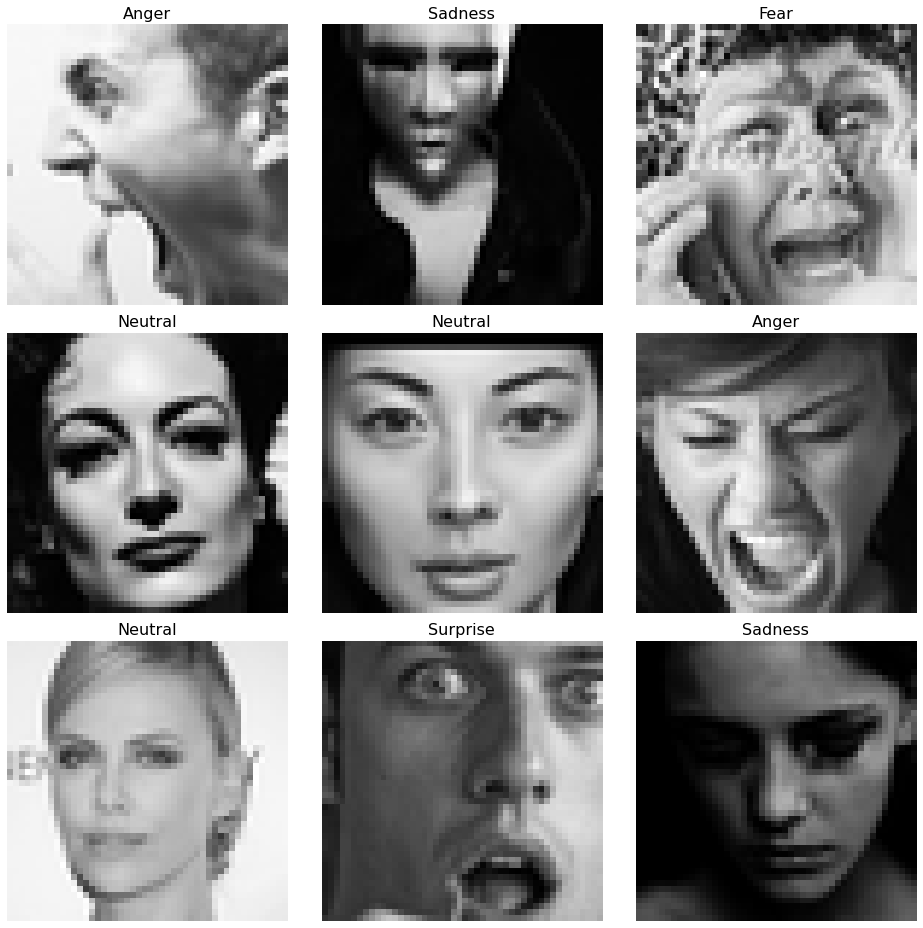

In [4]:
# Helper Functions
def display_one_image(image, title, subplot, color):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16)
    
def display_nine_images(images, titles, title_colors=None):
    subplot = 331
    plt.figure(figsize=(13,13))
    for i in range(9):
        color = 'black' if title_colors is None else title_colors[i]
        display_one_image(images[i], titles[i], 331+i, color)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

def image_title(label, prediction):
  # Both prediction (probabilities) and label (one-hot) are arrays with one item per class.
    class_idx = np.argmax(label, axis=-1)
    prediction_idx = np.argmax(prediction, axis=-1)
    if class_idx == prediction_idx:
        return f'{CLASS_LABELS[prediction_idx]} [correct]', 'black'
    else:
        return f'{CLASS_LABELS[prediction_idx]} [incorrect, should be {CLASS_LABELS[class_idx]}]', 'red'

def get_titles(images, labels, model):
    predictions = model.predict(images)
    titles, colors = [], []
    for label, prediction in zip(classes, predictions):
        title, color = image_title(label, prediction)
        titles.append(title)
        colors.append(color)
    return titles, colors

img_datagen = ImageDataGenerator(rescale = 1./255)
img_generator = img_datagen.flow_from_directory(directory = train_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )
clear_output()

images, classes = next(img_generator)
class_idxs = np.argmax(classes, axis=-1) 
labels = [CLASS_LABELS[idx] for idx in class_idxs]
display_nine_images(images, labels)

## Data distribution (count) among differnt emotions

In [5]:
fig = px.bar(x = CLASS_LABELS_EMOJIS,
             y = [list(train_generator.classes).count(i) for i in np.unique(train_generator.classes)] , 
             color = np.unique(train_generator.classes) ,
             color_continuous_scale="Emrld") 
fig.update_xaxes(title="Emotions")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Train Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

<a id="model"></a>
# <center> DenseNet169 Transfer Learning  </center>

DenseNet is a type of convolutional neural network use dense connections between layers. Developed to improve the declined accuracy.
The information from the input layer can reach the output layer more effectively, without getting lost along the way. All layers with matching feature-map sizes are directly connected with each other.

In [6]:
def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.DenseNet169(input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),
                                               include_top=False,
                                               weights="imagenet")(inputs)
    
    return feature_extractor

def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(256, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1024, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5) (x)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="classification")(x)
    
    return x

def final_model(inputs):
    densenet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(densenet_feature_extractor)
    
    return classification_output

def define_compile_model():
    
    inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT ,IMG_WIDTH,3))
    classification_output = final_model(inputs) 
    model = tf.keras.Model(inputs=inputs, outputs = classification_output)
     
    model.compile(optimizer=tf.keras.optimizers.SGD(0.1), 
                loss='categorical_crossentropy',
                metrics = ['accuracy'])
  
    return model

## Summary of model

In [7]:
model = define_compile_model()
clear_output()

# Feezing the feature extraction layers
model.layers[1].trainable = False

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
densenet169 (Functional)     (None, 1, 1, 1664)        12642880  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1664)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               426240    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              263168    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0     

<a id="train"></a>
# <center> Training and Fine-Tuning </center> 

## Training model with freezed layers of DenseNet169

In [8]:
earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                         patience=EARLY_STOPPING_CRITERIA,
                                                         verbose= 1 ,
                                                         restore_best_weights=True
                                                        )

history = model.fit(x = train_generator,
                    epochs = EPOCHS ,
                    validation_data = validation_generator , 
                    callbacks= [earlyStoppingCallback])

history = pd.DataFrame(history.history)

Epoch 1/30
180/180 [==============================] - 199s 990ms/step - loss: 12.6224 - accuracy: 0.3299 - val_loss: 9.4341 - val_accuracy: 0.1730
Epoch 2/30
180/180 [==============================] - 50s 277ms/step - loss: 6.6945 - accuracy: 0.4909 - val_loss: 5.6928 - val_accuracy: 0.1717
Epoch 3/30
180/180 [==============================] - 49s 273ms/step - loss: 3.8531 - accuracy: 0.5420 - val_loss: 3.5392 - val_accuracy: 0.2818
Epoch 4/30
180/180 [==============================] - 51s 281ms/step - loss: 2.4587 - accuracy: 0.5740 - val_loss: 2.2949 - val_accuracy: 0.4644
Epoch 5/30
180/180 [==============================] - 50s 279ms/step - loss: 1.7549 - accuracy: 0.5988 - val_loss: 1.6265 - val_accuracy: 0.5658
Epoch 6/30
180/180 [==============================] - 50s 275ms/step - loss: 1.4056 - accuracy: 0.6154 - val_loss: 1.3444 - val_accuracy: 0.6018
Epoch 7/30
180/180 [==============================] - 50s 280ms/step - loss: 1.2090 - accuracy: 0.6323 - val_loss: 1.2327 - val_

## Fine Tuning

In [9]:
# Un-Freezing the feature extraction layers for fine tuning 
model.layers[1].trainable = True

model.compile(optimizer=tf.keras.optimizers.SGD(0.001), #lower learning rate
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

history_ = model.fit(x = train_generator,epochs = FINE_TUNING_EPOCHS ,validation_data = validation_generator)
history = history.append(pd.DataFrame(history_.history) , ignore_index=True)

Epoch 1/50
180/180 [==============================] - 65s 291ms/step - loss: 0.8961 - accuracy: 0.7072 - val_loss: 1.0864 - val_accuracy: 0.6267
Epoch 2/50
180/180 [==============================] - 49s 273ms/step - loss: 0.8599 - accuracy: 0.7208 - val_loss: 1.0766 - val_accuracy: 0.6321
Epoch 3/50
180/180 [==============================] - 50s 276ms/step - loss: 0.8437 - accuracy: 0.7208 - val_loss: 1.0735 - val_accuracy: 0.6368
Epoch 4/50
180/180 [==============================] - 49s 271ms/step - loss: 0.8320 - accuracy: 0.7289 - val_loss: 1.0738 - val_accuracy: 0.6403
Epoch 5/50
180/180 [==============================] - 49s 274ms/step - loss: 0.8222 - accuracy: 0.7330 - val_loss: 1.0719 - val_accuracy: 0.6407
Epoch 6/50
180/180 [==============================] - 49s 271ms/step - loss: 0.8113 - accuracy: 0.7375 - val_loss: 1.0743 - val_accuracy: 0.6410
Epoch 7/50
180/180 [==============================] - 50s 278ms/step - loss: 0.8110 - accuracy: 0.7348 - val_loss: 1.0743 - val_ac

## Training plots

In [10]:
x = px.line(data_frame= history , y= ["accuracy" , "val_accuracy"] ,markers = True )
x.update_xaxes(title="Number of Epochs")
x.update_yaxes(title = "Accuracy")
x.update_layout(showlegend = True,
    title = {
        'text': 'Accuracy vs Number of Epochs',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
x.show()

In [11]:
x = px.line(data_frame= history , 
            y= ["loss" , "val_loss"] , markers = True )
x.update_xaxes(title="Number of Epochs")
x.update_yaxes(title = "Loss")
x.update_layout(showlegend = True,
    title = {
        'text': 'Loss vs Number of Epochs',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
x.show()

<a id="vis"></a>
# <center> Visualizing Results </center> 

## Model Evaluation

In [12]:
model.evaluate(test_generator)
preds = model.predict(test_generator)
y_preds = np.argmax(preds , axis = 1 )
y_test = np.array(test_generator.labels)

57/57 [==============================] - 47s 837ms/step - loss: 1.1494 - accuracy: 0.6513


## Confusion Matrix

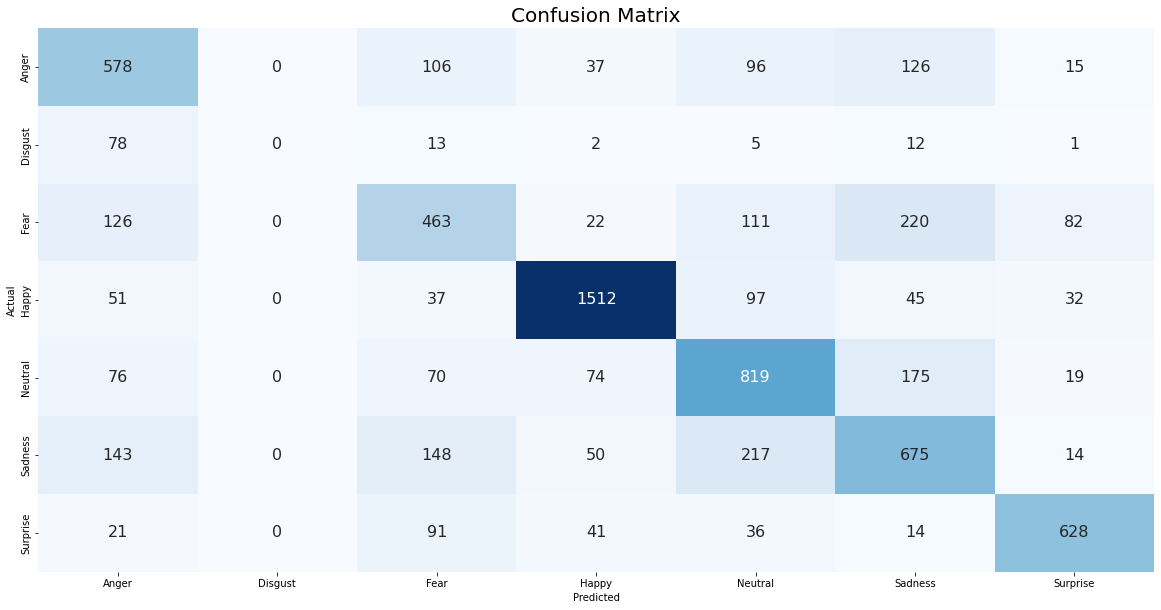

In [13]:
cm_data = confusion_matrix(y_test , y_preds)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

## Classification Report 

In [14]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.54      0.60      0.57       958
           1       0.00      0.00      0.00       111
           2       0.50      0.45      0.47      1024
           3       0.87      0.85      0.86      1774
           4       0.59      0.66      0.63      1233
           5       0.53      0.54      0.54      1247
           6       0.79      0.76      0.77       831

    accuracy                           0.65      7178
   macro avg       0.55      0.55      0.55      7178
weighted avg       0.64      0.65      0.65      7178



## Multiclass AUC Curve

ROC AUC score: 0.9169955138171668


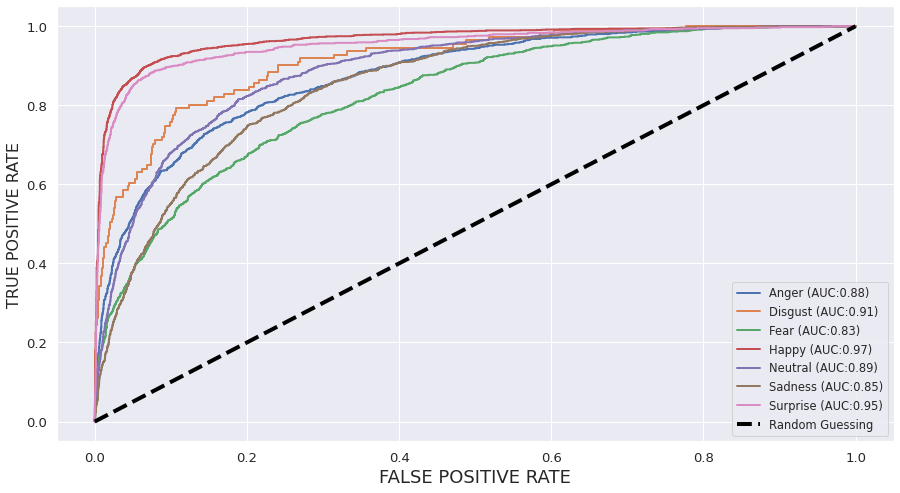

In [15]:
fig, c_ax = plt.subplots(1,1, figsize = (15,8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test , preds  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()

In [16]:
print("ROC-AUC Score  = " ,roc_auc_score(to_categorical(y_test) , preds))

ROC-AUC Score  =  0.896898716553539
